In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vnstock import *
from datetime import datetime
from sklearn.metrics import mean_squared_error
from vnstock.chart import * # import chart functions
from prophet import Prophet
from prophet.plot import plot_plotly,plot_components_plotly
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
import itertools
import torch
from copy import deepcopy as dc
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch.nn as nn
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
# Set Matplotlib defaults
sns.set_style('whitegrid')
plt.rc("figure", autolayout=True, figsize=(15, 8))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [9]:
df = stock_historical_data(symbol="FPT", start_date="2020-01-02", end_date="2023-12-25", resolution="1D", type="stock", beautify=True, decor=False, source='DNSE')

In [10]:
fig = candlestick_chart(df, ma_periods=[50,200], show_volume=False, reference_period=300, figure_size=(12, 6),
                        title='FPT - Candlestick Chart with MA and Volume', x_label='Date', y_label='Price',
                        colors=('lightgray', 'gray'), reference_colors=('black', 'blue'))

fig.show()

### Prepare data

In [11]:
# config
stock_target='FPT'
origin_start_date= datetime(2020, 1, 2)
start_date = datetime(2023, 8, 20)
end_date = datetime(2023, 12, 25)

In [12]:
def move_day(today): 
    if today.weekday() == 5:  # Saturday
     today += timedelta(days=2)
    elif today.weekday() == 6:  # Sunday
     today += timedelta(days=1)
    return today

def generate_date_range(start_date, end_date):
    # mapping to stock is that day exist 
    df_map = stock_historical_data(symbol=stock_target, start_date=start_date.strftime('%Y-%m-%d'),end_date=end_date.strftime('%Y-%m-%d'), resolution="1D", type="stock", beautify=True, decor=False, source='DNSE')
        
    return pd.to_datetime(df_map['time'])

def restore_df(X_scaler,y_scaler,scaler):

   num_features = 0
   # (number samples, number time steps, number features)
   if X_scaler.shape[1] == 1:
      num_features = X_scaler.shape[2]
   elif  X_scaler.shape[2] == 1:
      num_features = X_scaler.shape[1]  

   dummies = np.zeros((X_scaler.shape[0],num_features + 1))

   if  X_scaler.shape[1] == 1:
        # don't use timestep instead use features
       dummies[:,1:] = X_scaler.reshape((X_scaler.shape[0],X_scaler.shape[2]))
   elif X_scaler.shape[1] != 1:
       # use time steps
       dummies[:,1:] = X_scaler.reshape((X_scaler.shape[0],X_scaler.shape[1]))
   dummies[:, 0] = y_scaler.flatten()
   df = scaler.inverse_transform(dummies)
   return df

def get_predict_and_df(model, X, scaler):
    if not torch.is_tensor(X):
        X = torch.tensor(X).float() 
    
    with torch.no_grad():
       y_predicted = model(X.to(device)).to('cpu').numpy()
      
    y_predict = y_predicted.flatten()
    df = restore_df(X, y_predict, scaler)
    return df
   
def get_predict(model, X, scaler):
    with torch.no_grad():
      df = get_predict_and_df(model, X, scaler)
      return df[:,:1].reshape(df.shape[0])
    
def create_scaler_df(df):
     df_np = df.to_numpy()
     scaler = MinMaxScaler(feature_range = (0, 1))
     df_np_scaler = scaler.fit_transform(df_np)
     return df_np_scaler, scaler

def multi_scaler_df(df_list):
    df_np_scaler_list = []
    scaler_list = []
    for df in df_list:    
      df_np_scaler, scaler = create_scaler_df(df)
      df_np_scaler_list.append(df_np_scaler)
      scaler_list.append(scaler)
    return df_np_scaler_list, scaler_list


In [13]:
day_test_range = generate_date_range(start_date,end_date)

In [14]:
len(day_test_range)

89

In [15]:
def get_list_next_day_actual_test_range():
    begin_day = (day_test_range.iloc[0] + timedelta(days=1)).strftime('%Y-%m-%d')
    stop_day = (day_test_range.iloc[-1] + timedelta(days=1)).strftime('%Y-%m-%d')
    df_raw = stock_historical_data(symbol=stock_target, start_date=begin_day,end_date=stop_day, resolution="1D", type="stock", beautify=True, decor=False, source='DNSE')
    return df_raw

**Get the data**

In [17]:
df_fw_list = []
print("Get stock data from origin data 2020-01-02 to latest test day "+ end_date.strftime('%Y-%m-%d'))
df_raw = stock_historical_data(symbol=stock_target, start_date=origin_start_date.strftime('%Y-%m-%d') ,end_date=end_date.strftime('%Y-%m-%d'), resolution="1D", type="stock", beautify=True, decor=False, source='DNSE')
df_fw_gen = pd.DataFrame()
df_fw_gen[['ds','y']] = df_raw[['time','close']]
df_fw_gen['ds'] = pd.to_datetime(df_fw_gen['ds'] )

for upper_bound_date in  day_test_range:
    df_fw = dc(df_fw_gen[ df_fw_gen['ds'] <= upper_bound_date])
    print(f"Create samples set from {origin_start_date.strftime('%Y-%m-%d')} to {upper_bound_date.strftime('%Y-%m-%d')}")
    df_fw = df_fw.groupby('ds').mean().reset_index()
    df_fw_list.append(df_fw)

Get stock data from origin data 2020-01-02 to latest test day 2023-12-25


Create samples set from 2020-01-02 to 2023-08-21
Create samples set from 2020-01-02 to 2023-08-22
Create samples set from 2020-01-02 to 2023-08-23
Create samples set from 2020-01-02 to 2023-08-24
Create samples set from 2020-01-02 to 2023-08-25
Create samples set from 2020-01-02 to 2023-08-28
Create samples set from 2020-01-02 to 2023-08-29
Create samples set from 2020-01-02 to 2023-08-30
Create samples set from 2020-01-02 to 2023-08-31
Create samples set from 2020-01-02 to 2023-09-05
Create samples set from 2020-01-02 to 2023-09-06
Create samples set from 2020-01-02 to 2023-09-07
Create samples set from 2020-01-02 to 2023-09-08
Create samples set from 2020-01-02 to 2023-09-11
Create samples set from 2020-01-02 to 2023-09-12
Create samples set from 2020-01-02 to 2023-09-13
Create samples set from 2020-01-02 to 2023-09-14
Create samples set from 2020-01-02 to 2023-09-15
Create samples set from 2020-01-02 to 2023-09-18
Create samples set from 2020-01-02 to 2023-09-19
Create samples set f

In [18]:
my_df = df_fw_list[0]
my_df

,ds,y
0,2020-01-02,28950.0
1,2020-01-03,28460.0
2,2020-01-06,28160.0
3,2020-01-07,28700.0
4,2020-01-08,28060.0
...,...,...
903,2023-08-15,83030.0
904,2023-08-16,84120.0
905,2023-08-17,85010.0
906,2023-08-18,84510.0


### Statistics analysis on stock before build AIMA models

We opt for the initial train from the dataset for model analysis. Since financial series, such as stocks, typically stabilize at the first different, there is no need for further ADF testing. Instead, our focus shifts to determining the appropriate parameters Q and P.

In [19]:
my_df = df_fw_list[0]

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

Text(0.5, 0.98, 'ACF and PACF of 1st different FPT stock')

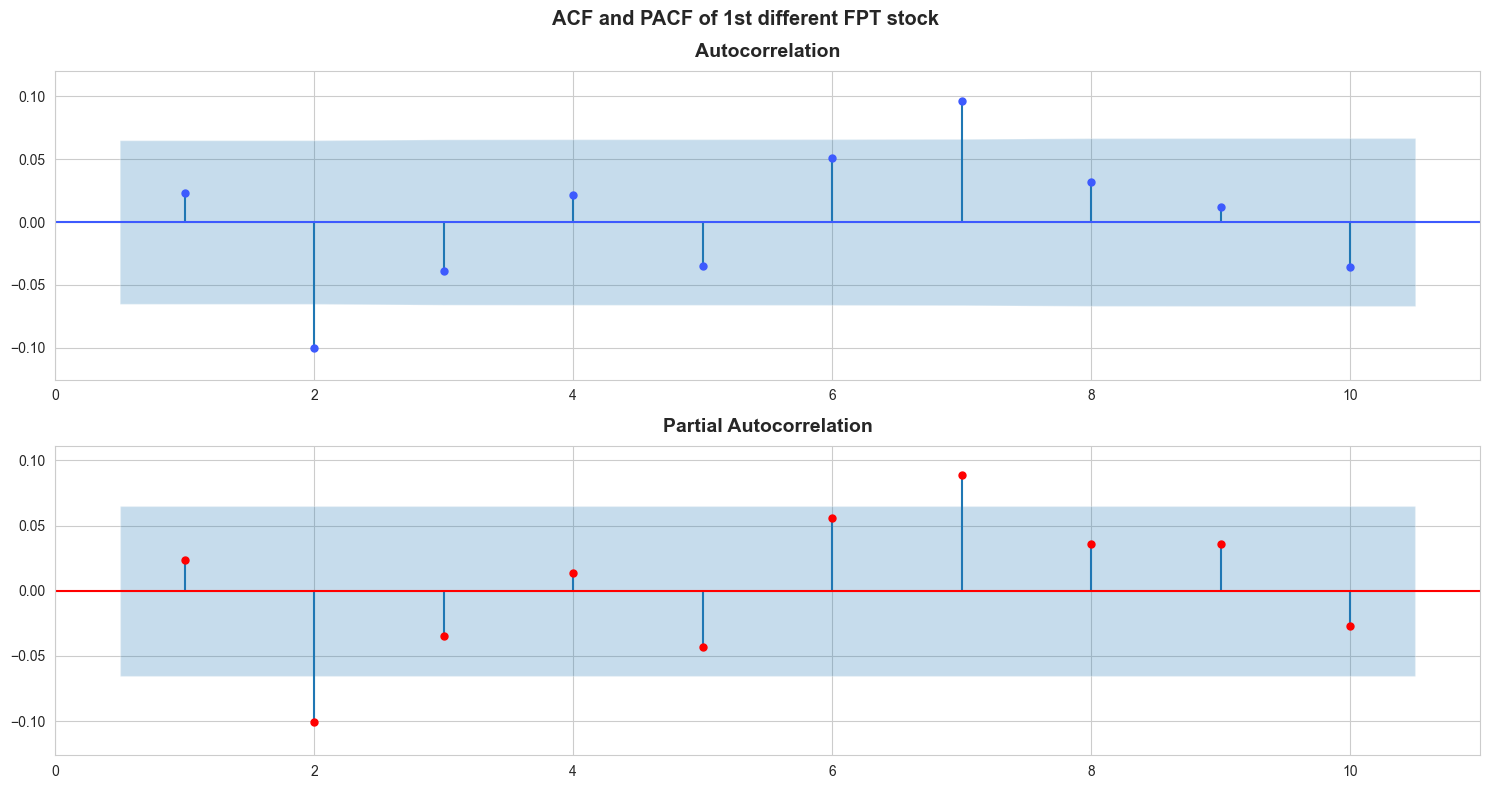

In [21]:
fig, ax = plt.subplots(2,1,figsize=(15, 8))
chart = plot_acf(my_df['y'].diff().dropna(),lags=range(1,11),ax=ax[0],auto_ylims=True,color='#3d5afe',markerfacecoloralt='green',alpha=0.05)
chart = plot_pacf(my_df['y'].diff().dropna(),lags=range(1,11),ax=ax[1],auto_ylims=True,color='red',alpha=0.05)
plt.suptitle(f"ACF and PACF of 1st different {stock_target} stock", fontsize="x-large",fontweight="bold")

In [22]:
acf, acf_ci = sm.tsa.acf(my_df['y'].diff().dropna(),nlags=10, alpha=0.05)
pacf, pacf_ci = sm.tsa.pacf(my_df['y'].diff().dropna(),nlags=10, alpha=0.05)

ac_table = pd.DataFrame(data={
    'lag': range(1,11),
    'acf_lower': acf_ci[1:,:1].reshape(10),
    'acf': acf[1:],
    'acf_upper': acf_ci[1:,1:].reshape(10),
    'pacf_lower': pacf_ci[1:,:1].reshape(10),
    'pacf': pacf[1:],
    'pacf_upper': pacf_ci[1:,1:].reshape(10),
})

ac_table

,lag,acf_lower,acf,acf_upper,pacf_lower,pacf,pacf_upper
0,1,-0.041604,0.023476,0.088555,-0.041578,0.023502,0.088581
1,2,-0.165484,-0.100368,-0.035253,-0.166278,-0.101199,-0.036119
2,3,-0.105076,-0.039309,0.026459,-0.099913,-0.034833,0.030246
3,4,-0.044226,0.021641,0.087508,-0.051569,0.013510,0.078590
4,5,-0.100648,-0.034751,0.031146,-0.108806,-0.043726,0.021354
5,6,-0.015044,0.050931,0.116905,-0.009089,0.055990,0.121070
6,7,0.030014,0.096155,0.162296,0.024247,0.089327,0.154406
7,8,-0.034802,0.031928,0.098659,-0.028994,0.036086,0.101165
8,9,-0.054516,0.012279,0.079074,-0.028888,0.036192,0.101271
9,10,-0.102319,-0.035514,0.031290,-0.092163,-0.027084,0.037996


Now keep the lags level that have significant.

In [23]:
significant_acf_lags = [i + 1 for i, ci in enumerate(acf_ci[1:]) if (ci[0] < 0 and ci[1] < 0) or (ci[0] > 0 and ci[1] > 0)]
significant_pacf_lags = [i + 1 for i, ci in enumerate(pacf_ci[1:]) if (ci[0] < 0 and ci[1] < 0) or (ci[0] > 0 and ci[1] > 0)]


### Hyper tunning parmaters for ARIMA model

We use our each sample data  split it in into train set have length by samples length minus 10 to train model and predict the once next day. After that we add the actual next day totrain set continue predict the next next day. Repeat this process until the length of the training set matches the total available training data, excluding one. Then we chose the model that have smallest RMSE.

In [24]:
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [25]:
def build_model(train_data, p_list ,q_list):
      # Initial approximation of parameters
    Ps = p_list
    Qs = q_list
    d=[1]
    parameters = product(Ps,d,Qs)
    parameters_list = list(parameters)

    # Model Selection
    models = []
    for param in parameters_list:
        try:
            model = ARIMA(train_data, order=(param[0], param[1], param[2])).fit()
        except ValueError:
            print(parameters_list)
            continue
        models.append(model)
    return models  

In [26]:
evaluate_table = pd.DataFrame(columns=['Model','Scenario','RMSE'])


In [27]:
choose_model_table = pd.DataFrame()
total_len = len(my_df['y'])
for idx in range(10):
  X_train = my_df['y'][:total_len - 10 + idx]
  X_test = my_df['y'][total_len - 10 + idx: total_len - 10 + idx+ 1]
  models = build_model(X_train, significant_acf_lags , significant_pacf_lags)
  for model in models:
     choose_model_table = pd.concat([choose_model_table,pd.DataFrame({
         'params': [(len(model.arparams),1,len(model.maparams))],
          # predict the next day
         'predict': np.array(model.forecast(steps=1)),
         'actual': X_test,
     })],axis=0)


c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\sit

In [28]:
df_model_eval = pd.DataFrame(choose_model_table.groupby('params').apply(lambda df: np.sqrt(mean_squared_error(df['actual'],df['predict']))))
df_model_eval.columns = ['rmse']
df_model_eval.reset_index(inplace=True)


In [29]:
len(df_model_eval['params'].unique())

4

In [30]:
# Create a bar plot using plotly.graph_objects
fig = go.Figure()

fig.add_trace(go.Bar(
    # not conver have wire error 
    x=df_model_eval['params'].astype(str),
    y=df_model_eval['rmse'],
    text=df_model_eval['rmse'],
    hoverinfo='text',
    marker=dict(color='skyblue'),
))

# Customize the layout if needed
fig.update_layout(
    title=f'{stock_target} RMSE for Different ARIMA Parameter Sets',
    xaxis=dict(title='Parameter Sets', type='category'),
    yaxis=dict(title='RMSE'),
)

# Show the plot
fig.show()

We see the RMSE don't  too much different between the paramter sets around 800 dong, but ARIMA(2,1,2) still have smallest RMSE so will choose it for next stage (the backtest model stage).

In [31]:
(best_p,_,best_q) = df_model_eval.loc[df_model_eval['rmse'].idxmin()]['params']
(best_p,_,best_q)

(2, 1, 2)

### Back testing on period from 22/8/203 to 26/8/2023

In [32]:
list_model = []

for df in df_fw_list:
    models = build_model(df['y'], [best_p], [best_q])
    for model in models:
        list_model.append(model)


c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\sit

In [33]:
results = pd.Series()
for  model in list_model:
     forecast = model.forecast(steps=1)      
     results =  pd.concat([results,forecast],axis=0)

In [34]:
y_actual = get_list_next_day_actual_test_range()
y_actual[['ds','y']] = y_actual[['time','close']]
y_actual = y_actual[['ds','y']]
y_actual['ds'] =  pd.to_datetime(y_actual['ds'])

In [35]:
compare_table = pd.DataFrame({
     'ds': y_actual['ds'],
     'y': y_actual['y'],
     'yhat': results.values
})
compare_table

,ds,y,yhat
0,2023-08-22,85500,84941.052312
1,2023-08-23,85500,85484.592997
2,2023-08-24,90000,85445.720740
3,2023-08-25,90600,90064.305992
4,2023-08-28,94000,90252.706660
...,...,...,...
84,2023-12-20,94700,94844.184932
85,2023-12-21,95100,94656.319438
86,2023-12-22,94600,94979.199499
87,2023-12-25,96000,94610.143147


In [36]:
compare_table['y_change'] = compare_table['y'].diff()
compare_table['yhat_change'] = compare_table['yhat'].diff()
compare_table['y*yhat_chage'] = compare_table['y_change'] * compare_table['yhat_change']

In [37]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(compare_table['y'], compare_table['yhat']))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate correlation coefficient
correlation = compare_table['y'].corr(compare_table['yhat'])
print(f"Correlation Coefficient: {correlation}")

truth = []
for y_hat_change, y_change in zip(compare_table['yhat'].diff().dropna(),compare_table['y'].diff().dropna()):
    truth.append(1 if y_hat_change * y_change > 0 else 0)


print(f"Direction correction ratio: {np.sum(truth)/len(truth) * 100}")

r2 = r2_score(compare_table['y'], compare_table['yhat'])
print(f"R-squared (R²): {r2}")

Root Mean Squared Error (RMSE): 1557.416222057185
Correlation Coefficient: 0.9021290849708213
Direction correction ratio: 39.77272727272727
R-squared (R²): 0.7968885332942577


In [38]:
df_mtr = pd.read_csv('./output/metrics-FPT.csv')
# remove old record
df_mtr = df_mtr[~(df_mtr['model'] == f'ARIMA{best_p,1,best_p}')]

df_mtr = pd.concat([df_mtr,
                    pd.DataFrame({
                     'model': [f'ARIMA{best_p,1,best_p}'],
                     'rmse': [rmse],
                     'correlation': [correlation],
                     'r-squared': [r2] })], axis=0)
df_mtr.to_csv('./output/metrics-FPT.csv',index=False)

df_mtr

,model,rmse,r-squared,correlation
1,"LSTM(1,4,1)",3441.145454,0.008412,0.618331
2,Prophet,3743.512032,-0.174072,0.416017
3,Prophet-LSTM,2314.104455,0.551574,0.864688
0,"ARIMA(2, 1, 2)",1557.416222,0.796889,0.902129


In [39]:
# Plotting with Plotly
fig = go.Figure()

# Plot yhat as a line
fig.add_trace(go.Scatter(x=compare_table['ds'], y=compare_table['yhat'], mode='lines+markers', name='yhat', line=dict(color='blue')))

# Plot y as points
fig.add_trace(go.Scatter(x=compare_table['ds'], y=compare_table['y'], mode='lines+markers', name='y', marker=dict(color='red', size=8)))

# Set layout
fig.update_layout(title=f'{stock_target} moving forward train and predict the next day with ARIMA{best_p,1,best_q}',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  showlegend=True)

# Show the plot
fig.show()

### Hybrid ARIMA and LSTM 

We use the predict and it's 3 lags result from ARIMA as input and the 2 lags t-1, t-2 of resid features to LSTM and the target variables still the stock price. The reason is that LSTM can capture some pattern ARIMA may be miss

In [40]:
from copy import deepcopy as dc

In [41]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]


In [42]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                        batch_first = True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

In [43]:
def create_predict_list():
     predict_list = []
     for  model, df  in zip(list_model, df_fw_list):
      predict = model.get_prediction().predicted_mean
      df = dc(df)
      df['yhat'] = predict
      df['resid'] = model.resid
      predict_list.append(df)
     
     return predict_list

In [44]:
df_predict_list = create_predict_list()

In [45]:
df_predict_list[0]

,ds,y,yhat,resid
0,2020-01-02,28950.0,0.000000,28950.000000
1,2020-01-03,28460.0,29182.627502,-722.627502
2,2020-01-06,28160.0,27276.471365,883.528635
3,2020-01-07,28700.0,27950.862487,749.137513
4,2020-01-08,28060.0,28722.738784,-662.738784
...,...,...,...,...
903,2023-08-15,83030.0,81692.741540,1337.258460
904,2023-08-16,84120.0,83007.543954,1112.456046
905,2023-08-17,85010.0,84014.371903,995.628097
906,2023-08-18,84510.0,84910.639201,-400.639201


In [46]:
LSTM_loop_back=3
LSTM_lstm_input_cols = ['y','yhat']
LSTM_resid_loop_back = 2

shifted_df_LSTM_list = []

def prepare_dataframe_grach_for_lstm(df, n_steps, resid_loop_back):
  df = dc(df)[LSTM_lstm_input_cols]
  for i in range(1, n_steps + 1):
    df[f'yhat(t-{i})'] = df['yhat'].shift(i)
  for i in range(1,resid_loop_back+1):
      df[f'resid(t-{i})'] = (df['y'] - df['yhat']).shift(i)

  return df

for df in df_predict_list:
   shifted_df  = prepare_dataframe_grach_for_lstm(df,LSTM_loop_back,LSTM_resid_loop_back)
   shifted_df_LSTM_list.append(shifted_df)


In [47]:
shifted_df_LSTM_list[0]

,y,yhat,yhat(t-1),yhat(t-2),yhat(t-3),resid(t-1),resid(t-2)
0,28950.0,0.000000,NaN,NaN,NaN,NaN,NaN
1,28460.0,29182.627502,0.000000,NaN,NaN,28950.000000,NaN
2,28160.0,27276.471365,29182.627502,0.000000,NaN,-722.627502,28950.000000
3,28700.0,27950.862487,27276.471365,29182.627502,0.000000,883.528635,-722.627502
4,28060.0,28722.738784,27950.862487,27276.471365,29182.627502,749.137513,883.528635
...,...,...,...,...,...,...,...
903,83030.0,81692.741540,81138.839819,81328.212654,82126.459815,511.160181,-278.212654
904,84120.0,83007.543954,81692.741540,81138.839819,81328.212654,1337.258460,511.160181
905,85010.0,84014.371903,83007.543954,81692.741540,81138.839819,1112.456046,1337.258460
906,84510.0,84910.639201,84014.371903,83007.543954,81692.741540,995.628097,1112.456046


In [48]:
scaler_LSTM_input_list, scaler_LSTM_list = multi_scaler_df([df_shifted.dropna() for df_shifted in shifted_df_LSTM_list])

In [49]:
scaler_LSTM_input_list[0]

array([[0.13435819, 0.12253189, 0.11214287, ..., 0.        , 0.61967802,
        0.45957727],
       [0.1245196 , 0.13442269, 0.12253189, ..., 0.34513581, 0.60628199,
        0.61967802],
       [0.13066872, 0.12350114, 0.13442269, ..., 0.32259217, 0.46554694,
        0.60628199],
       ...,
       [1.        , 0.98619296, 0.97068273, ..., 0.95960924, 0.64249738,
        0.66490556],
       [0.9923136 , 1.        , 0.98619296, ..., 0.9661601 , 0.63085203,
        0.64249738],
       [0.99846272, 0.99226732, 1.        , ..., 0.98170995, 0.49167288,
        0.63085203]])

In [50]:
X_list = []
y_list = []

for shifted_df_scaler in scaler_LSTM_input_list:
    X = shifted_df_scaler[:, 1:]
    y = shifted_df_scaler[:, 0:1]
    X_list.append(X)
    y_list.append(y)

In [51]:
X_train_list = [X_train.reshape((-1, 1, LSTM_loop_back+ 1 + LSTM_resid_loop_back)) for X_train in X_list]
y_train_list =  [y_train.reshape((-1, 1)) for y_train in y_list]

In [52]:
X_train_list = [torch.tensor(X_train).float() for X_train in X_train_list]
y_train_list = [torch.tensor(y_train).float() for y_train in y_train_list]

X_train_list[0].shape, y_train_list[0].shape

(torch.Size([905, 1, 6]), torch.Size([905, 1]))

In [53]:
train_dataset_list = [TimeSeriesDataset(X_train, y_train) for X_train, y_train in zip(X_train_list,y_train_list)]

In [54]:
from torch.utils.data import DataLoader
batch_size = 12

train_loader_list = [DataLoader(train_dataset, batch_size = batch_size, shuffle = True) for train_dataset in train_dataset_list ]

In [55]:
train_loader_list[0]

#### Init LSTM model 6,4,1

In [56]:
list_LSTM_model = []

for i in range(len(train_loader_list)):
  m = LSTM(6, 4, 1) #1,4,1 19:30
  m.to(device)
  list_LSTM_model.append(m)

list_LSTM_model[0]

LSTM(
  (lstm): LSTM(6, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [57]:
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()

def train_one_epoch(model,train_loader,epoch):
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  model.train(True)
  print(f'Epoch: {epoch + 1}')
  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 20 == 10: # print every 10 batches
        avg_loss_across_batches = running_loss / 1
        print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                              avg_loss_across_batches))
        running_loss = 0.0
  print()

In [58]:
for model, train_loader in zip(list_LSTM_model,train_loader_list):
  for epoch in range(num_epochs):
    train_one_epoch(model=model,train_loader=train_loader,epoch=epoch)

Epoch: 1
Batch 11, Loss: 3.944
Batch 31, Loss: 6.425
Batch 51, Loss: 5.301
Batch 71, Loss: 3.916

Epoch: 2
Batch 11, Loss: 1.721
Batch 31, Loss: 2.923
Batch 51, Loss: 2.085
Batch 71, Loss: 1.863

Epoch: 3
Batch 11, Loss: 0.763
Batch 31, Loss: 1.241
Batch 51, Loss: 1.046
Batch 71, Loss: 0.928

Epoch: 4
Batch 11, Loss: 0.441
Batch 31, Loss: 0.771
Batch 51, Loss: 0.618
Batch 71, Loss: 0.496

Epoch: 5
Batch 11, Loss: 0.244
Batch 31, Loss: 0.318
Batch 51, Loss: 0.218
Batch 71, Loss: 0.130

Epoch: 6
Batch 11, Loss: 0.051
Batch 31, Loss: 0.050
Batch 51, Loss: 0.021
Batch 71, Loss: 0.017

Epoch: 7
Batch 11, Loss: 0.010
Batch 31, Loss: 0.022
Batch 51, Loss: 0.016
Batch 71, Loss: 0.013

Epoch: 8
Batch 11, Loss: 0.008
Batch 31, Loss: 0.016
Batch 51, Loss: 0.015
Batch 71, Loss: 0.015

Epoch: 9
Batch 11, Loss: 0.008
Batch 31, Loss: 0.012
Batch 51, Loss: 0.017
Batch 71, Loss: 0.014

Epoch: 10
Batch 11, Loss: 0.009
Batch 31, Loss: 0.013
Batch 51, Loss: 0.012
Batch 71, Loss: 0.011

Epoch: 11
Batch 11,

In [74]:
my_df = df_fw_list[0].reset_index()


fig = go.Figure()

actual_scat = go.Scatter(x=my_df['ds'][LSTM_loop_back:], y=my_df['y'][LSTM_loop_back:], mode='lines', name="Actual Price y", line=dict(color='red'))

# get predict
predicted = get_predict(model=list_LSTM_model[0],X=X_train_list[0], scaler=scaler_LSTM_list[0])
# plot it
predicted_scat = go.Scatter(x=my_df['ds'][LSTM_loop_back:], y=predicted, mode='lines', name="ARIMA-LSTM Predict Price yhat", line=dict(color='blue'))

prop_predicted_scat = go.Scatter(x=my_df['ds'][LSTM_loop_back:], y=df_predict_list[0]['yhat'][LSTM_loop_back:], mode='lines', name=f"ARIMA{best_p,1,best_q}", line=dict(color='green'))


fig.add_trace(actual_scat)
fig.add_trace(prop_predicted_scat)
fig.add_trace(predicted_scat)
fig.update_layout(title_text=f'{stock_target} a random horizon in samples predict')
       

In [60]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(my_df['y'][LSTM_loop_back:], df_predict_list[0]['yhat'][LSTM_loop_back:])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"ARIMA{best_p,1,best_q} Root Mean Squared Error (RMSE): {rmse}")
print(f"Correlation: {np.corrcoef(my_df['y'][LSTM_loop_back:],  df_predict_list[0]['yhat'][LSTM_loop_back:])[0,1]}")

ARIMA(2, 1, 2) Root Mean Squared Error (RMSE): 983.0627255831716
Correlation: 0.9985737568938664


In [61]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(my_df['y'][LSTM_loop_back:], predicted)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"ARIMA-LSTM Root Mean Squared Error (RMSE): {rmse}")

print(f"Correlation: {np.corrcoef(my_df['y'][LSTM_loop_back:], predicted)[0,1]}")



ARIMA-LSTM Root Mean Squared Error (RMSE): 1190.365989630239
Correlation: 0.9979361706732328


#### Moving Forward Predict for ARIMA-LSTM

In [62]:
def create_X_LSTM(X, scaler, number_features):
    X = np.atleast_2d(np.array(X))
    yX = np.atleast_2d(np.append(np.zeros((X.shape[0], 1)),X))
    yX_scaler = scaler.transform(yX)
    X_3D = yX_scaler[:,1:].reshape((-1, 1, number_features))
    return X_3D


def create_X_predict_next_day(arima_model, shifted_df_LSTM):
    forecast = arima_model.forecast(steps=1)
    # get the current yhat -> yhat(t - LSTM_loop_back -1) total is LSTM_loop_back
    lag_yhat = shifted_df_LSTM.iloc[-1:,1:1+LSTM_loop_back]
    # skip oldest yhat cols and get from latest reisd to oldest resid - 1
    lag_resid = shifted_df_LSTM.iloc[-1:, 1+ LSTM_loop_back + 1: -1]
    current_reisd = (shifted_df_LSTM[-1:]['y'] - shifted_df_LSTM[-1:]['yhat'])
    next_yhat = forecast
    #return create_X_LSTM(np.append(lag_X,latest_X,axis=0))
    merge_X = np.concatenate((np.array(next_yhat).flatten(),np.array(lag_yhat).flatten(),np.array(current_reisd).flatten(),np.array(lag_resid).flatten()),axis=0)
    return merge_X

def get_predict_next_day(LSTM_model,scaler,arima_model,shifted_df_LSTM):
    X_predict_next_day = create_X_predict_next_day(arima_model,shifted_df_LSTM) 
    X_scaler = create_X_LSTM(X_predict_next_day, scaler, LSTM_loop_back + 1 + LSTM_resid_loop_back)
    y_predict_next_day = get_predict(LSTM_model, X_scaler, scaler)[-1:]
    return y_predict_next_day[0]


In [63]:
def get_list_next_day_predict_test_range():
    next_days = []
    for LSTM_model, scaler, arima_model, shifted_df_LSTM  in zip(list_LSTM_model, scaler_LSTM_list, list_model, shifted_df_LSTM_list):
      next_day_predict = get_predict_next_day(model, scaler, arima_model, shifted_df_LSTM)
      next_days.append(next_day_predict)
    return np.array(next_days).reshape(len(next_days))



def create_evalute_table():
    next_days = get_list_next_day_predict_test_range()
    df = get_list_next_day_actual_test_range()
    df['predict'] = pd.Series(next_days)
    df[['ds','y','yhat']] = df[['time','close','predict']]
    df = df[['ds','y','yhat']]
    df['ds'] = pd.to_datetime(df['ds'])
    return df

In [65]:
get_list_next_day_actual_test_range()

,time,open,high,low,close,volume,ticker
0,2023-08-22,85300,85500,82040,85500,2330300,FPT
1,2023-08-23,85400,85800,83720,85500,1418500,FPT
2,2023-08-24,85500,90100,85100,90000,5251600,FPT
3,2023-08-25,89500,91000,89100,90600,2791400,FPT
4,2023-08-28,92000,94300,91000,94000,2950700,FPT
...,...,...,...,...,...,...,...
84,2023-12-20,94300,95000,94100,94700,1349500,FPT
85,2023-12-21,94600,95100,94000,95100,1756800,FPT
86,2023-12-22,95000,95100,94400,94600,1275400,FPT
87,2023-12-25,94900,96200,94800,96000,2017000,FPT


In [68]:
df_eval = create_evalute_table()
df_eval['y_change'] = df_eval['y'].diff()
df_eval['yhat_change'] = df_eval['yhat'].diff()
df_eval['y*yhat_chage'] = df_eval['y_change'] * df_eval['yhat_change']

In [69]:
df_eval

,ds,y,yhat,y_change,yhat_change,y*yhat_chage
0,2023-08-22,85500,83888.038621,NaN,NaN,NaN
1,2023-08-23,85500,84772.510288,0.0,884.471667,0.000000e+00
2,2023-08-24,90000,84586.983340,4500.0,-185.526948,-8.348713e+05
3,2023-08-25,90600,91760.950837,600.0,7173.967497,4.304380e+06
4,2023-08-28,94000,91400.966530,3400.0,-359.984307,-1.223947e+06
...,...,...,...,...,...,...
84,2023-12-20,94700,93838.010559,100.0,1086.692963,1.086693e+05
85,2023-12-21,95100,94122.078838,400.0,284.068279,1.136273e+05
86,2023-12-22,94600,94428.190594,-500.0,306.111755,-1.530559e+05
87,2023-12-25,96000,93800.048103,1400.0,-628.142490,-8.793995e+05


In [70]:
from sklearn.metrics import r2_score

In [71]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df_eval['y'], df_eval['yhat']))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate correlation coefficient
correlation = df_eval['y'].corr(df_eval['yhat'])
print(f"Correlation Coefficient: {correlation}")

truth = []
for y_hat_change, y_change in zip(df_eval['yhat'].diff().dropna(),df_eval['y'].diff().dropna()):
    truth.append(1 if y_hat_change * y_change > 0 else 0)


print(f"Direction correction ratio: {np.sum(truth)/len(truth) * 100}")


r2 = r2_score(compare_table['y'], compare_table['yhat'])
print(f"R-squared (R²): {r2}")

Root Mean Squared Error (RMSE): 1688.8496527056534
Correlation Coefficient: 0.8919956828055388
Direction correction ratio: 37.5
R-squared (R²): 0.7968885332942577


In [72]:
df_mtr = pd.read_csv('./output/metrics-FPT.csv')
# remove old record
df_mtr = df_mtr[~(df_mtr['model'] == 'ARIMA-LSTM')]

df_mtr = pd.concat([df_mtr,
                    pd.DataFrame({
                     'model': ['ARIMA-LSTM'],
                     'rmse': [rmse],
                     'correlation': [correlation],
                     'r-squared': [r2] })], axis=0)
df_mtr.to_csv('./output/metrics-FPT.csv',index=False)

In [75]:
# Plotting with Plotly
fig = go.Figure()

# Plot yhat as a line
fig.add_trace(go.Scatter(x=df_eval['ds'], y=df_eval['yhat'], mode='lines+markers', name='yhat', line=dict(color='blue')))

# Plot y as points
fig.add_trace(go.Scatter(x=df_eval['ds'], y=df_eval['y'], mode='lines+markers', name='y', marker=dict(color='red', size=8)))

# Set layout
fig.update_layout(title=f'ARIMA{best_p,1,best_q}-LSTM {stock_target} moving forward train and predict the next day with ARIMA-LSTM',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  showlegend=True)

# Show the plot
fig.show()